# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

## Importação de Pacotes e Base de Dados

In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline

In [285]:
# Salva a base de dados em 'df'
df = pd.read_feather('../Dados/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [287]:
# Verifica as datas nas quais foram obtidos os dados
df['data_ref'].value_counts()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [288]:
# Separa os 3 últimos meses (ano de 2016) como validacao oot, removendo o 'index'
oot = df[df.data_ref.dt.year == 2016].drop(columns = 'index')

# Separa os meses restantes (ano de 2015) como base de desenvolvimento, removendo o 'index'
desenvolvimento = df[df.data_ref.dt.year == 2015].drop(columns = 'index')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [290]:
# Número de linhas e colunas na base de desenvolvimento
print('Número de linhas: {0} \nNúmero de colunas: {1}'.format(desenvolvimento.shape[0], desenvolvimento.shape[1]))

Número de linhas: 600000 
Número de colunas: 14


In [291]:
# Número de linhas para cada mês
desenvolvimento.data_ref.dt.month.value_counts()

data_ref
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: count, dtype: int64

### Descritiva Básica Univariada das Variáveis Quantitativas
> As variáveis quantitativas da base de desenvolvimento são: 'idade', 'tempo_emprego' e 'renda'. Fazendo a análise descritiva delas:

In [293]:
# Lista com as variaveis quantitativas
quantitativas = ['idade','tempo_emprego','renda']

# Retorna a análise destas variáveis (média, mediana, contagem, etc)
desenvolvimento[quantitativas].describe()

,idade,tempo_emprego,renda
count,600000.000000,499125.000000,6.000000e+05
mean,43.798530,7.747992,2.722284e+04
std,11.230659,6.688576,8.737788e+04
min,22.000000,0.117808,1.618600e+02
25%,34.000000,3.049315,4.670600e+03
50%,43.000000,6.046575,9.887580e+03
75%,53.000000,10.180822,2.162887e+04
max,68.000000,42.906849,4.083986e+06


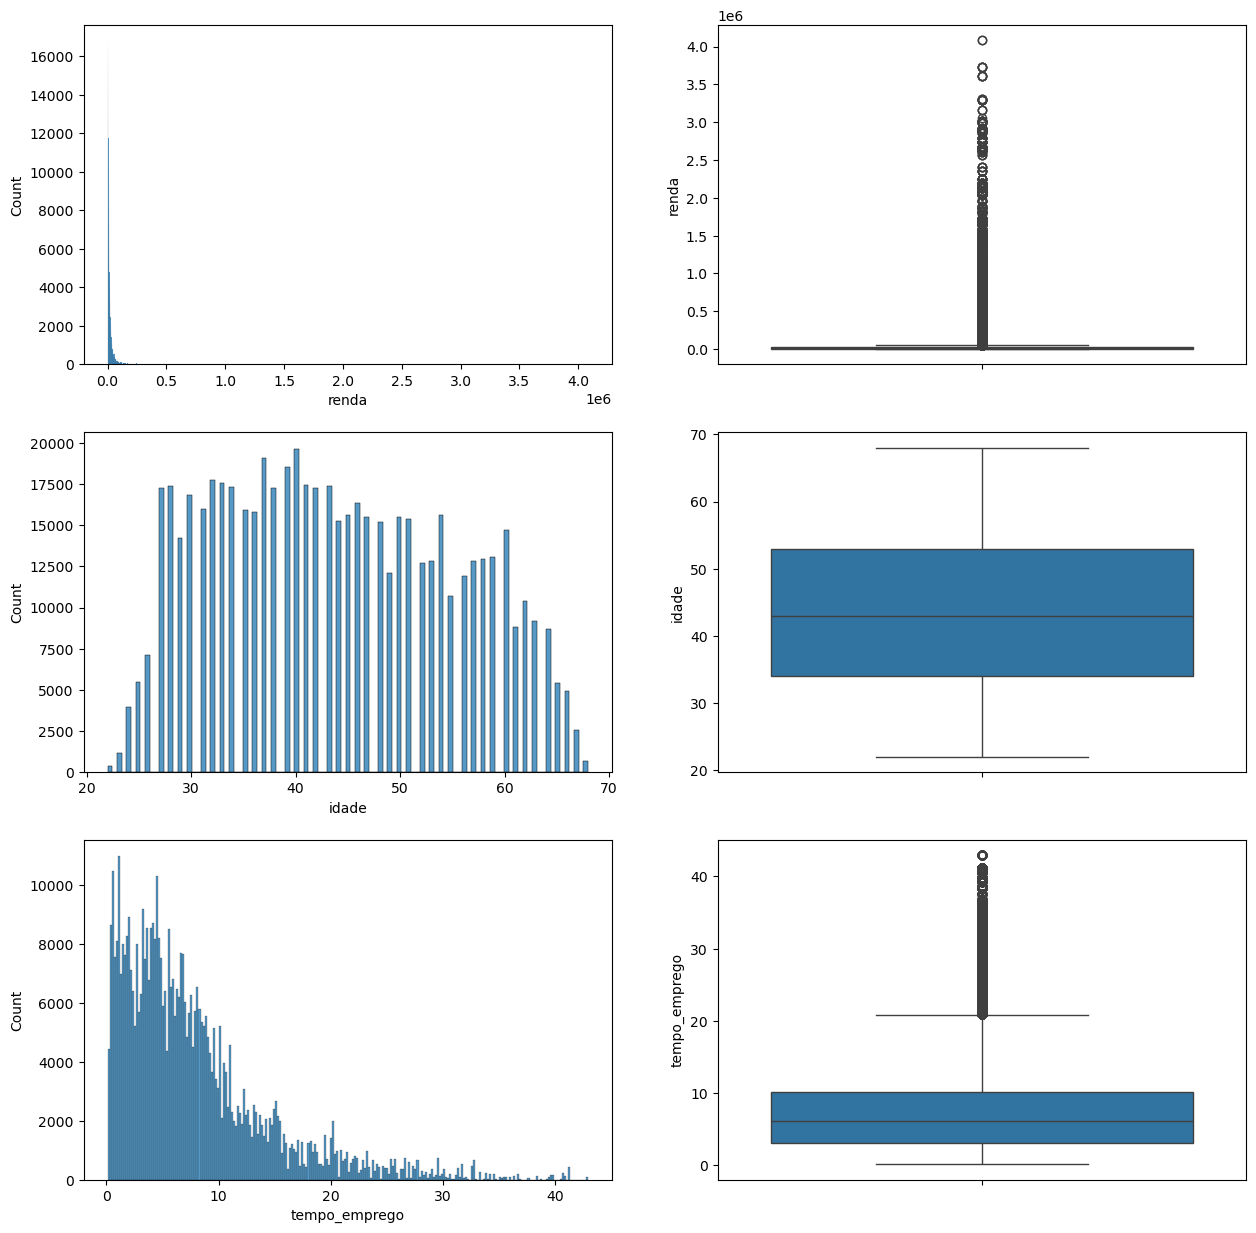

In [294]:
# Gráfico boxplot e contagem de cada variável quantitativa
plt.rc('figure', figsize=(15, 15))
fig, axes = plt.subplots(3, 2)

# 'renda'
sns.histplot(x='renda', data=desenvolvimento, ax = axes[0,0])
sns.boxplot(y='renda', data=desenvolvimento, ax = axes[0,1])

# 'idade'
sns.histplot(x='idade', data=desenvolvimento, ax = axes[1,0])
sns.boxplot(y='idade', data=desenvolvimento, ax = axes[1,1])

# 'tempo_emprego'
sns.histplot(x='tempo_emprego', data=desenvolvimento, ax = axes[2,0])
sns.boxplot(y='tempo_emprego', data=desenvolvimento, ax = axes[2,1])

# Mostra o gráfico
plt.show()

### Descritiva Básica Univariada das Variáveis Qualitativas
> São variáveis qualitativas todas as restantes, ou seja: 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia' e 'mau'.
>
> Fazendo a análise descritiva univariada de cada uma:

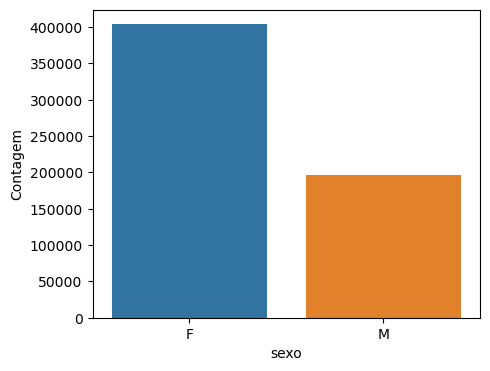

sexo
F    403805
M    196195
Name: count, dtype: int64

In [296]:
# Gráfico de barras da variável 'sexo'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='sexo', data=desenvolvimento, hue='sexo')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de indivíduos de cada sexo
desenvolvimento.sexo.value_counts()

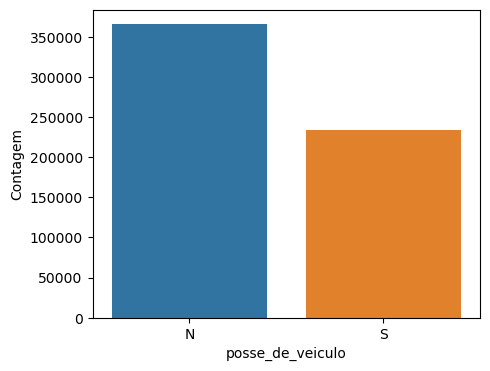

posse_de_veiculo
N    366293
S    233707
Name: count, dtype: int64

In [297]:
# Gráfico de barras da variável 'posse_de_veiculo'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='posse_de_veiculo', data=desenvolvimento, hue='posse_de_veiculo')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de pessoas com veículo
desenvolvimento.posse_de_veiculo.value_counts()

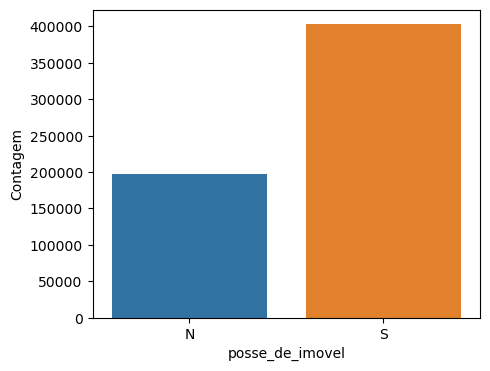

posse_de_imovel
S    403054
N    196946
Name: count, dtype: int64

In [298]:
# Gráfico de barras da variável 'posse_de_imovel'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='posse_de_imovel', data=desenvolvimento, hue='posse_de_imovel')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de pessoas com imóvel
desenvolvimento.posse_de_imovel.value_counts()

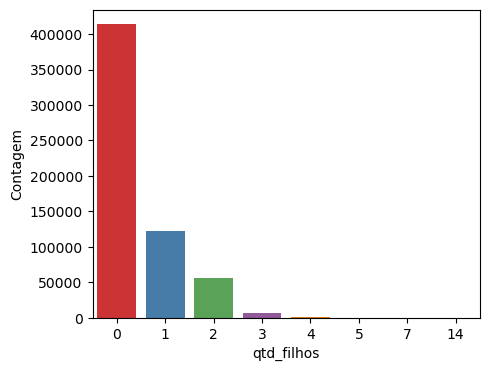

qtd_filhos
0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: count, dtype: int64

In [299]:
# Gráfico de barras da variável 'qtd_filhos'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='qtd_filhos', data=desenvolvimento, hue='qtd_filhos', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra as contagens da quantidade de filhos
desenvolvimento.qtd_filhos.value_counts()

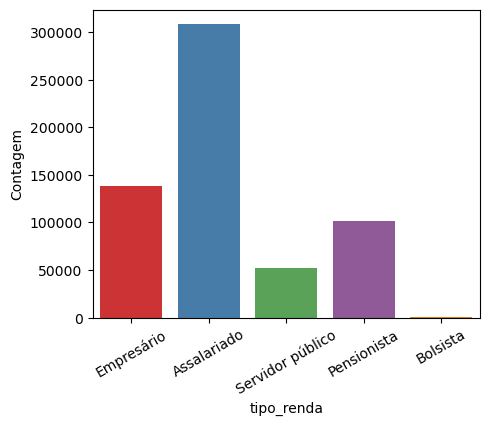

tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64

In [300]:
# Gráfico de barras da variável 'tipo_renda'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='tipo_renda', data=desenvolvimento, hue='tipo_renda', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.tick_params(axis='x', rotation=30)
plt.show()

# Mostra as contagens do tipo de renda
desenvolvimento.tipo_renda.value_counts()

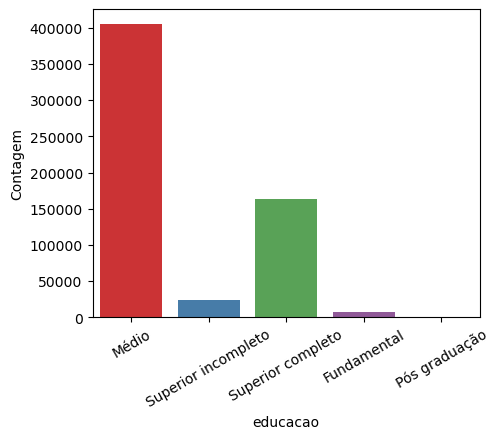

educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64

In [301]:
# Gráfico de barras da variável 'educacao'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='educacao', data=desenvolvimento, hue='educacao', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.tick_params(axis='x', rotation=30)
plt.show()

# Mostra as contagens do nível educacional
desenvolvimento.educacao.value_counts()

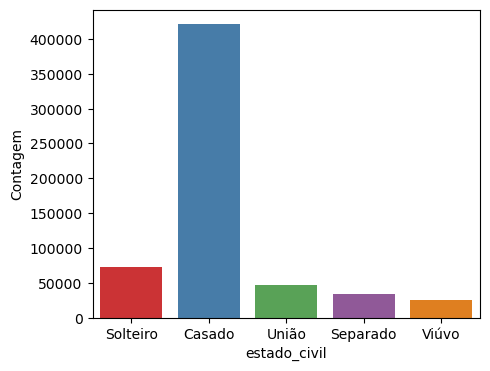

estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64

In [302]:
# Gráfico de barras da variável 'estado_civil'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='estado_civil', data=desenvolvimento, hue='estado_civil', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra as contagens do estado civil
desenvolvimento.estado_civil.value_counts()

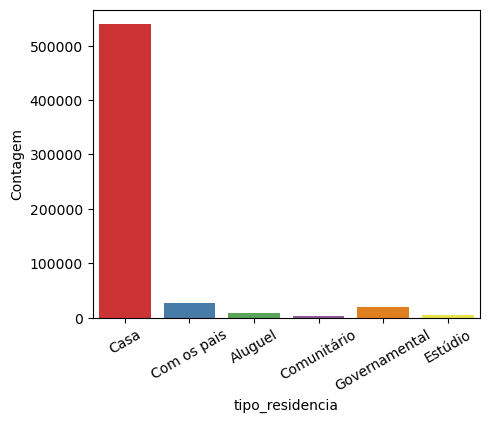

tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64

In [303]:
# Gráfico de barras da variável 'tipo_residencia'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='tipo_residencia', data=desenvolvimento, hue='tipo_residencia', 
              palette='Set1', legend=False)
plt.tick_params(axis='x', rotation=30)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem dos tipos de residencia
desenvolvimento.tipo_residencia.value_counts()

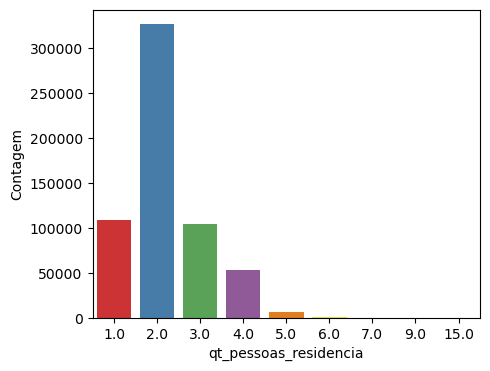

qt_pessoas_residencia
2.0     326181
1.0     108657
3.0     104126
4.0      53314
5.0       6638
6.0        890
9.0         82
15.0        71
7.0         41
Name: count, dtype: int64

In [304]:
# Gráfico de barras da variável 'qt_pessoas_residencia'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='qt_pessoas_residencia', data=desenvolvimento, 
              hue='qt_pessoas_residencia', palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem da quantidade de pessoas por residencia
desenvolvimento.qt_pessoas_residencia.value_counts()

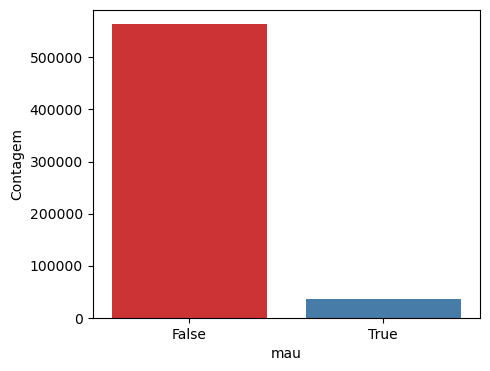

mau
False    563357
True      36643
Name: count, dtype: int64

In [305]:
# Gráfico de barras da variável 'mau'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='mau', data=desenvolvimento, 
              hue='mau', palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem de devedores
desenvolvimento.mau.value_counts()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

> A análise descritiva bivariada consiste no cálculo do _Informartion Value_ e gráfico de WOE de cada variável. No caso das variáveis contínuas, elas são divididas em 5 grupos antes do cálculo do IV.
>
> Para realizar estas etapas, serão utilizadas as funções **IV**, **biv_discreta** e **biv_continua** desenvolvidas em aula.

In [308]:
# Função que calcula o IV da variável selecionada desenvolvido em aula:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [309]:
# Função que imprime o gráfico WOE para cada categoria da variável discreta
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(biv[var], biv.woe, ':bo', label='woe')
    ax.plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax.set_xlim([-.3, num_cat-.7])

    ax.set_ylabel("Weight of Evidence")
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax.set_xticks(list(range(num_cat)))
    ax.set_xticklabels(biv[var], rotation=30)

    return biv

In [310]:
# Função que imprime o WOE de cada grupo da variável contínua
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(biv[var], biv.woe, ':bo', label='woe')
    ax.plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax.set_ylabel("Weight of Evidence")
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    return None

### Tabela de metadados com o _IV_ de cada variável explicativa:

In [312]:
# Cria a tabela 'metadados'
metadados = pd.DataFrame(desenvolvimento.drop('data_ref', axis=1).dtypes, 
                         columns=['dtype'])
metadados['nmissing'] = desenvolvimento.isna().sum()
metadados['valores_unicos'] = desenvolvimento.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

# Calcula o IV de cada variável explicativa
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>5) and (metadados.loc[var, 'dtype']!='object'):
        metadados.loc[var, 'IV'] = IV(pd.qcut(desenvolvimento[var],5,duplicates='drop'), 
                                      desenvolvimento.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(desenvolvimento[var], desenvolvimento.mau)

# Mostra a tabela resultante    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.000055
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,100875,3004,covariavel,0.360581


### WOE das variáveis discretas

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


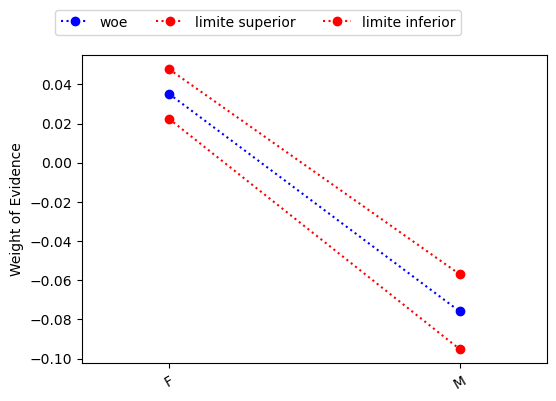

In [314]:
# WOE da variável 'sexo'
biv_discreta('sexo', desenvolvimento)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


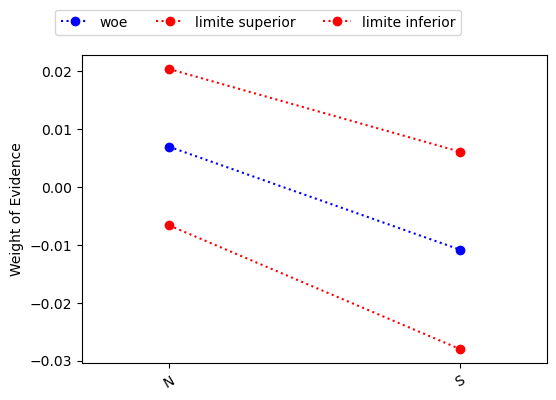

In [315]:
# WOE da variável 'posse_de_veiculo'
biv_discreta('posse_de_veiculo', desenvolvimento)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


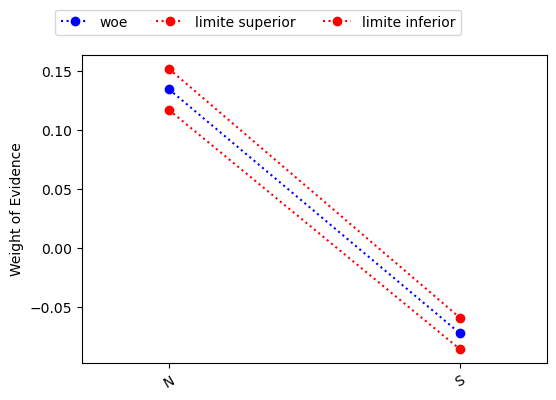

In [316]:
# WOE da variável 'posse_de_imovel'
biv_discreta('posse_de_imovel', desenvolvimento)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


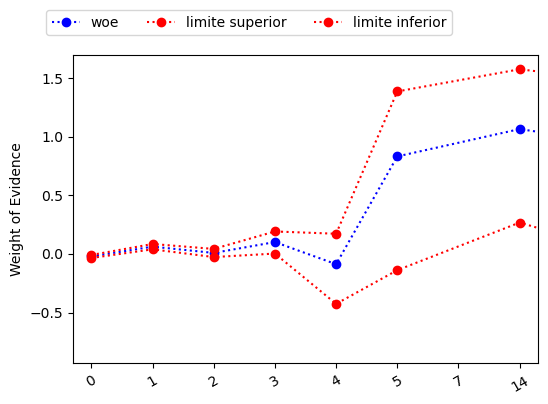

In [317]:
# WOE da variável 'qtd_filhos'
biv_discreta('qtd_filhos', desenvolvimento)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


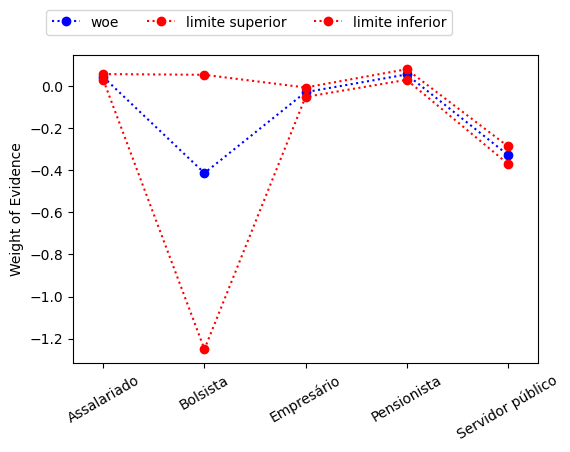

In [318]:
# WOE da variável 'tipo_renda'
biv_discreta('tipo_renda', desenvolvimento)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


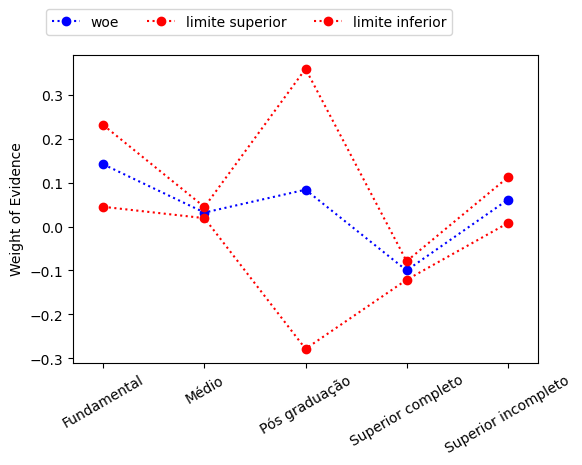

In [319]:
# WOE da variável 'educacao'
biv_discreta('educacao', desenvolvimento)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


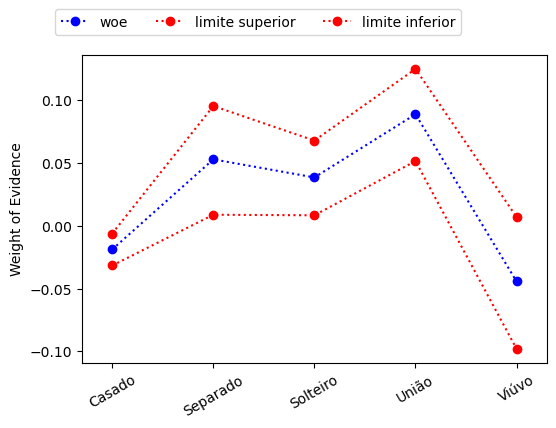

In [320]:
# WOE da variável 'estado_civil'
biv_discreta('estado_civil', desenvolvimento)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


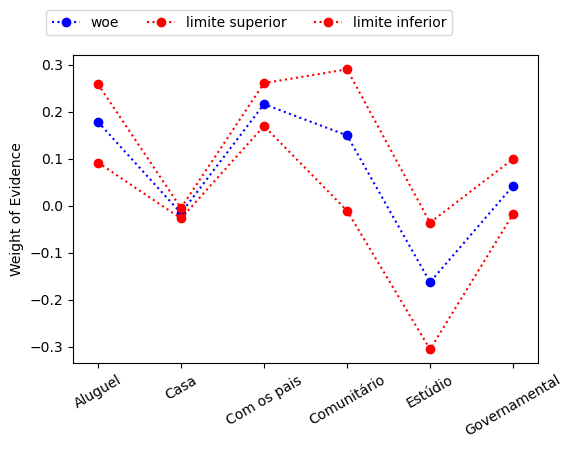

In [321]:
# WOE da variável 'tipo_residencia'
biv_discreta('tipo_residencia', desenvolvimento)

C:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


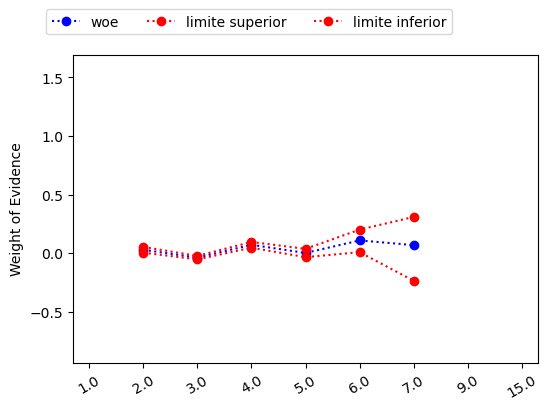

In [322]:
# WOE da variável 'qt_pessoas_residencia'
biv_discreta('qt_pessoas_residencia', desenvolvimento)

### WOE das Variáveis Contínuas

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\4075035406.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


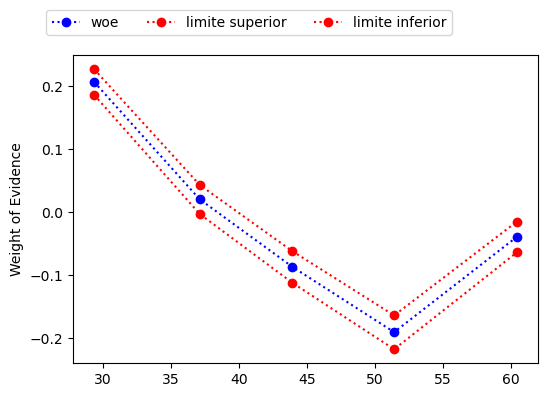

In [324]:
# WOE da variável 'idade'
biv_continua('idade', 5, desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\4075035406.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


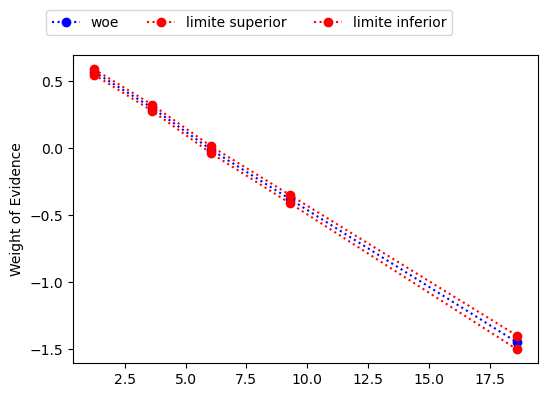

In [325]:
# WOE da variável 'tempo_emprego'
biv_continua('tempo_emprego', 5, desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\4075035406.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


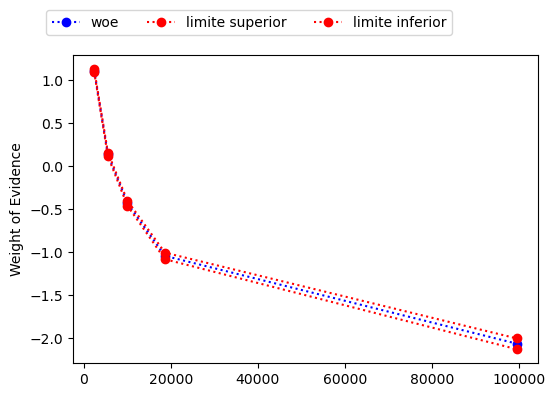

In [326]:
# WOE da variável 'renda'
biv_continua('renda', 5, desenvolvimento)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratamento de missings e outliers

> A descritiva básica univariada mostrou que há uma grande quantidade de variáveis outliers nas variáveis 'renda' e 'tempo_emprego', sendo que, no primeiro caso, correspondem aos valores superiores a aproximadamente 30000; enquanto que no segundo caso, é o tempo superior a aproximadamente 20 anos. Em vista disso, vamos remover todos estes outliers.
>
> Além disso, a única variável que apresentou valores missings foi a 'tempo_emprego'. Para resolver isso, serão removidos os dados faltantes.

In [329]:
# Remove os outliers das variáveis 'renda' e 'tempo_emprego'
desenvolvimento = desenvolvimento[(desenvolvimento['renda'] < 30000) & 
                                   (desenvolvimento['tempo_emprego'] < 21)]

# Remove os valores missings da variável 'tempo_emprego'
desenvolvimento = desenvolvimento.dropna()

> Analisando graficamente como ficaram as distribuições univariadas das variáveis quantitativas:

               idade  tempo_emprego         renda
count  398759.000000  398759.000000  398759.00000
mean       39.565131       5.677959    9681.84026
std         9.203267       4.066304    7205.81287
min        22.000000       0.117808     161.86000
25%        32.000000       2.432877    3915.54000
50%        39.000000       4.860274    7624.05000
75%        46.000000       8.060274   13885.64000
max        66.000000      20.931507   29999.88000


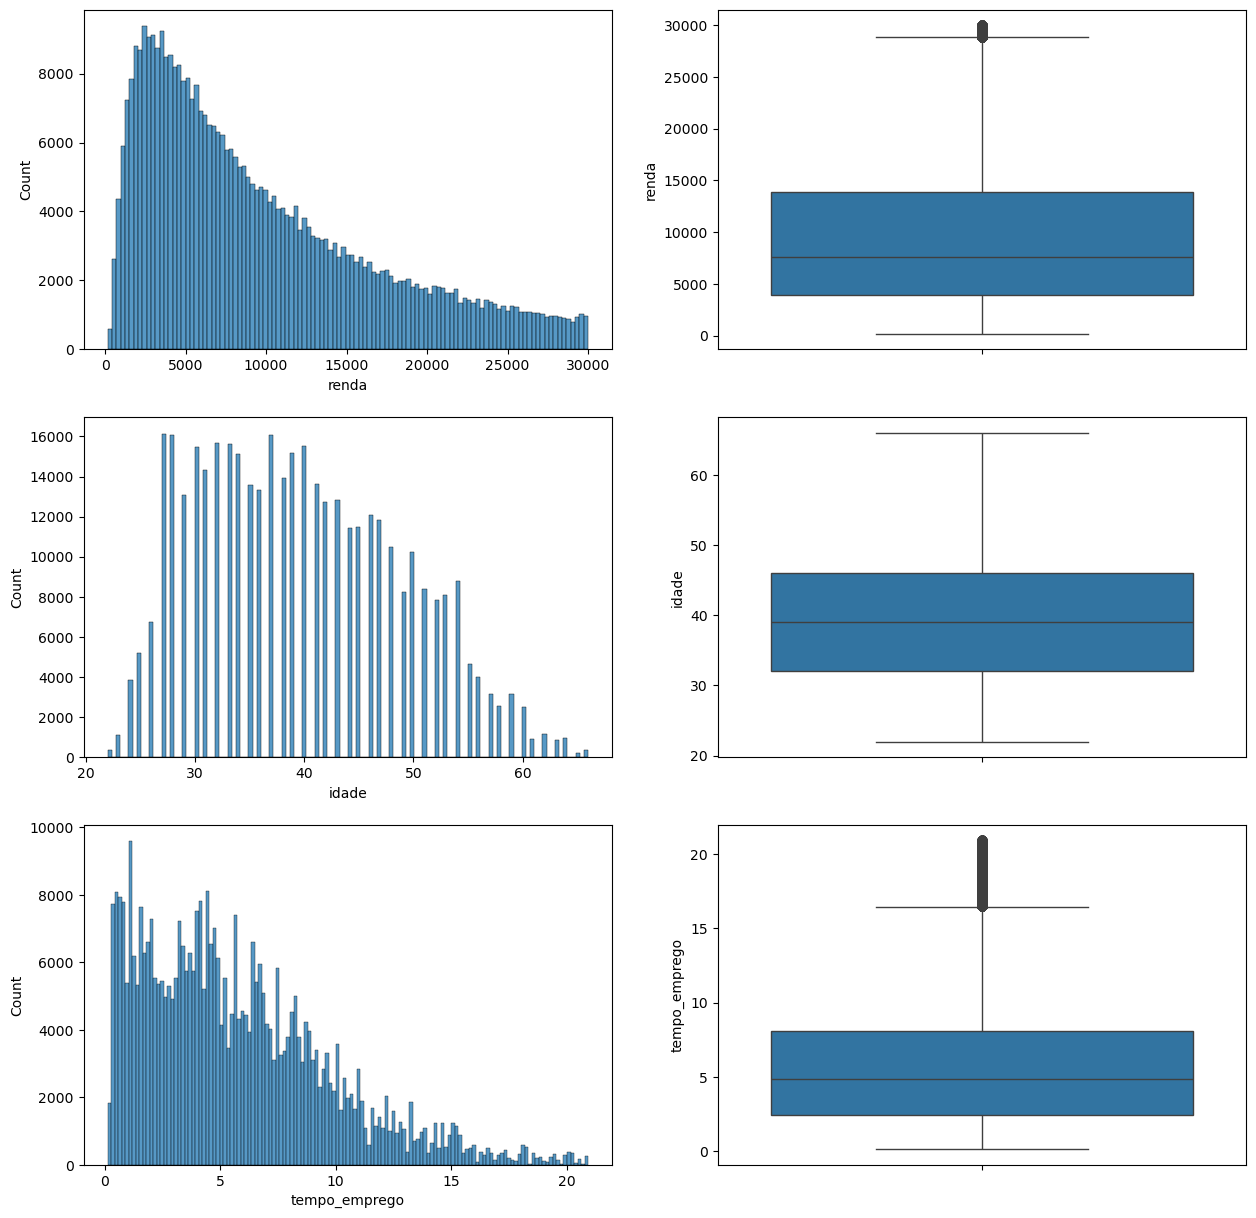

In [331]:
# Retorna a análise destas variáveis (média, mediana, contagem, etc)
print(desenvolvimento[quantitativas].describe())

# Gráfico boxplot e contagem de cada variável quantitativa
plt.rc('figure', figsize=(15, 15))
fig, axes = plt.subplots(3, 2)

# 'renda'
sns.histplot(x='renda', data=desenvolvimento, ax = axes[0,0])
sns.boxplot(y='renda', data=desenvolvimento, ax = axes[0,1])

# 'idade'
sns.histplot(x='idade', data=desenvolvimento, ax = axes[1,0])
sns.boxplot(y='idade', data=desenvolvimento, ax = axes[1,1])

# 'tempo_emprego'
sns.histplot(x='tempo_emprego', data=desenvolvimento, ax = axes[2,0])
sns.boxplot(y='tempo_emprego', data=desenvolvimento, ax = axes[2,1])

# Mostra o gráfico
plt.show()

### Tratamento de Zeros Estruturais e Agrupamento de Categorias

> Para resolver os zeros estruturais, as categorias que apresentam baixas quantidades em cada variável qualitativas serão combinadas em uma única. Em relação às variáveis quantitativas, cada uma delas será divida em 5 agrupamentos.

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\372268515.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.qtd_filhos.replace({0:'0', 1:'1', 2:'2', 3:'3 ou mais',


,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,227069,18012,0.073494,0,245081,0.000527,0.074527,0.072461,-2.534216,-2.519141,-2.549487,-0.004946,0.010129,-0.020217
1,93546,7590,0.075047,1,101136,0.000828,0.076671,0.073424,-2.511622,-2.488459,-2.535250,0.017648,0.040811,-0.005980
2,42629,3314,0.072133,2,45943,0.001207,0.074499,0.069767,-2.554379,-2.519556,-2.590271,-0.025109,0.009714,-0.061002
3 ou mais,6074,525,0.079558,3 ou mais,6599,0.003331,0.086088,0.073027,-2.448374,-2.362368,-2.541091,0.080895,0.166902,-0.011821


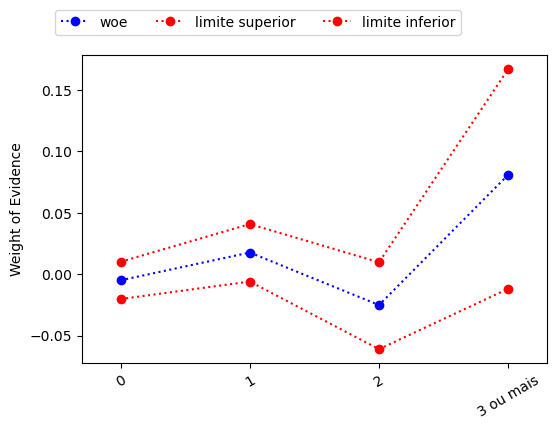

In [333]:
# Reagrupando a variável 'qtd_filhos'
desenvolvimento.qtd_filhos.replace({0:'0', 1:'1', 2:'2', 3:'3 ou mais', 
                                    4: '3 ou mais', 5: '3 ou mais', 
                                    6: '3 ou mais', 7: '3 ou mais', 
                                    14: '3 ou mais'}, inplace=True)
biv_discreta('qtd_filhos', desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\2276377735.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.tipo_renda.replace({'Bolsista': 'Bols./Serv.Pub./Pens.',


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,230593,19158,0.076708,Assalariado,249751,0.000533,0.077752,0.075665,-2.487934,-2.473288,-2.502764,0.041336,0.055982,0.026506
Bols./Serv.Pub./Pens.,33591,2277,0.063483,Bols./Serv.Pub./Pens.,35868,0.001287,0.066006,0.060959,-2.691399,-2.649721,-2.734652,-0.162130,-0.120451,-0.205382
Empresário,105134,8006,0.070762,Empresário,113140,0.000762,0.072256,0.069268,-2.575044,-2.552539,-2.597993,-0.045775,-0.023269,-0.068723


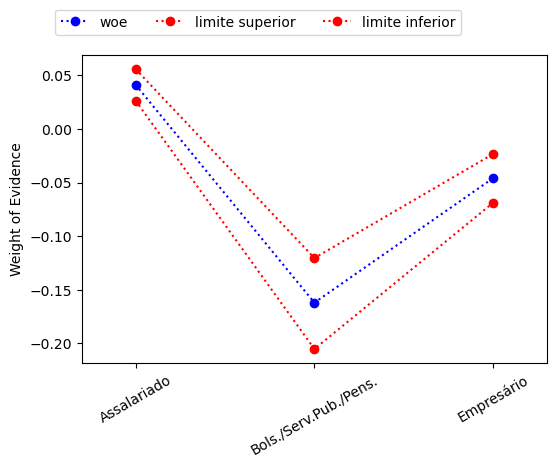

In [334]:
# Reagrupando a variável 'tipo_renda'
desenvolvimento.tipo_renda.replace({'Bolsista': 'Bols./Serv.Pub./Pens.', 
                                    'Servidor público': 'Bols./Serv.Pub./Pens.',
                                    'Pensionista': 'Bols./Serv.Pub./Pens.'}, 
                                   inplace=True)
biv_discreta('tipo_renda', desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\2912499854.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.educacao.replace({'Fundamental': 'Fundamental/Médio',


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Acadêmico,126400,9389,0.069144,Acadêmico,135789,0.000688,0.070493,0.067795,-2.599913,-2.579134,-2.621070,-0.070643,-0.049865,-0.091800
Fundamental/Médio,242918,20052,0.076252,Fundamental/Médio,262970,0.000518,0.077266,0.075238,-2.494395,-2.480081,-2.508885,0.034875,0.049189,0.020385


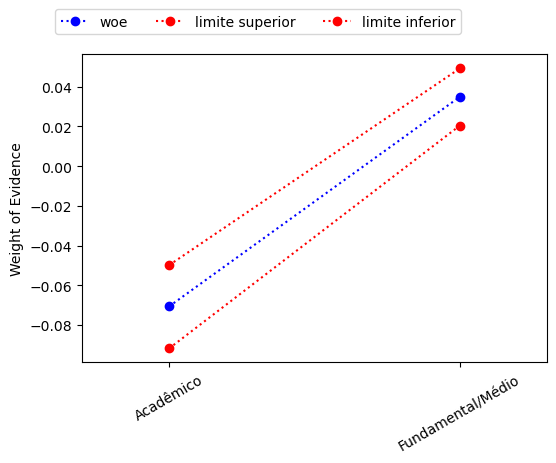

In [335]:
# Reagrupando a variável 'educacao'
desenvolvimento.educacao.replace({'Fundamental': 'Fundamental/Médio', 
                                  'Médio': 'Fundamental/Médio',
                                  'Superior incompleto': 'Acadêmico',
                                  'Superior completo': 'Acadêmico',
                                  'Pós graduação': 'Acadêmico'}, 
                                   inplace=True)
biv_discreta('educacao', desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\609090427.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.estado_civil.replace({'Separado': 'Separado/Viúvo',


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,264611,20661,0.072426,Casado,285272,0.000485,0.073377,0.071474,-2.550013,-2.535940,-2.564257,-0.020743,-0.006670,-0.034988
Separado/Viúvo,28649,2333,0.075302,Separado/Viúvo,30982,0.001499,0.078240,0.072363,-2.507964,-2.466501,-2.550940,0.021306,0.062769,-0.021670
Solteiro,46276,3872,0.077211,Solteiro,50148,0.001192,0.079548,0.074875,-2.480852,-2.448508,-2.514106,0.048418,0.080762,0.015164
União,29782,2575,0.079581,União,32357,0.001505,0.082530,0.076632,-2.448055,-2.408459,-2.489014,0.081215,0.120811,0.040255


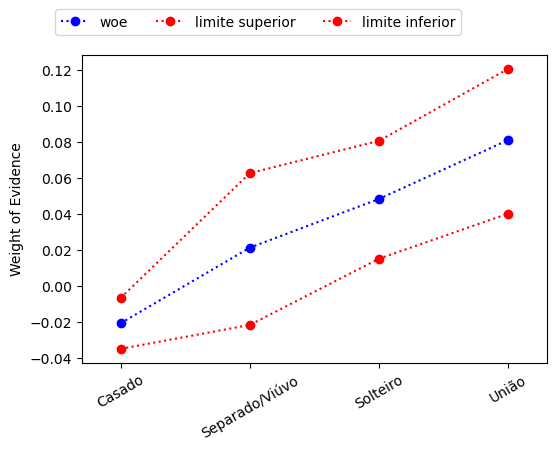

In [336]:
# Reagrupando a variável 'estado_civil'
desenvolvimento.estado_civil.replace({'Separado': 'Separado/Viúvo', 
                                      'Viúvo': 'Separado/Viúvo'}, 
                                      inplace=True)
biv_discreta('estado_civil', desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\58638274.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.tipo_residencia.replace({'Comunitário': 'Comun./Gov.',


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel/Estúdio,8875,758,0.078688,Aluguel/Estúdio,9633,0.002743,0.084065,0.073310,-2.460310,-2.388351,-2.536917,0.068960,0.140919,-0.007647
Casa,325482,25556,0.072801,Casa,351038,0.000439,0.073661,0.071942,-2.544435,-2.531771,-2.557237,-0.015165,-0.002501,-0.027968
Com os pais,21638,1970,0.083446,Com os pais,23608,0.001800,0.086974,0.079918,-2.396417,-2.351152,-2.443457,0.132852,0.178118,0.085813
Comun./Gov.,13323,1157,0.079903,Comun./Gov.,14480,0.002253,0.084320,0.075487,-2.443661,-2.385048,-2.505312,0.085608,0.144222,0.023957


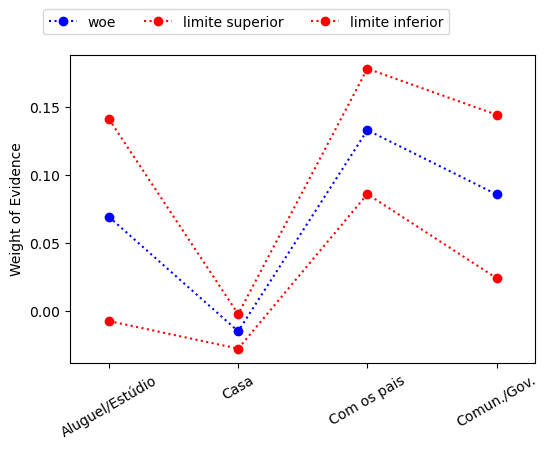

In [337]:
# Reagrupando a variável 'tipo_residencia'
desenvolvimento.tipo_residencia.replace({'Comunitário': 'Comun./Gov.',
                                         'Governamental': 'Comun./Gov.',
                                         'Aluguel': 'Aluguel/Estúdio',
                                         'Estúdio': 'Aluguel/Estúdio'},
                                         inplace=True)
biv_discreta('tipo_residencia', desenvolvimento)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13532\3800416857.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  desenvolvimento.qt_pessoas_residencia.replace({1: '1', 2: '2', 3: '3',


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1,57303,4772,0.076875,1,62075,0.001069,0.078970,0.074779,-2.485587,-2.456419,-2.515494,0.043682,0.072851,0.013776
2,185180,14499,0.072612,2,199679,0.000581,0.073750,0.071473,-2.547249,-2.530467,-2.564275,-0.017979,-0.001197,-0.035005
3,80148,6504,0.075059,3,86652,0.000895,0.076813,0.073304,-2.511458,-2.486455,-2.537003,0.017812,0.042815,-0.007734
4 ou mais,46687,3666,0.072806,4 ou mais,50353,0.001158,0.075075,0.070537,-2.544365,-2.511219,-2.578476,-0.015095,0.018051,-0.049206


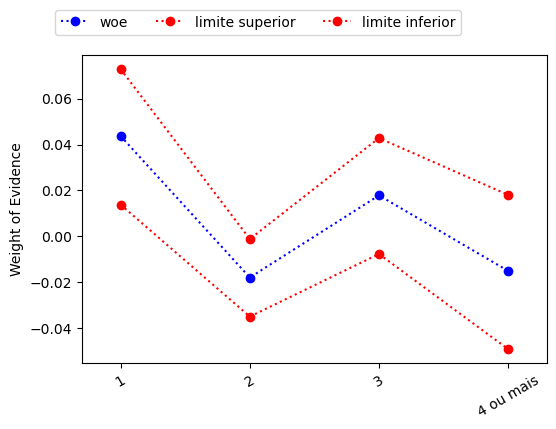

In [338]:
# Reagrupando a variável 'qt_pessoas_residencia'
desenvolvimento.qt_pessoas_residencia.replace({1: '1', 2: '2', 3: '3', 
                                               4: '4 ou mais',
                                               5: '4 ou mais',
                                               6: '4 ou mais',
                                               7: '4 ou mais',
                                               9: '4 ou mais',
                                               15: '4 ou mais'},
                                         inplace=True)
biv_discreta('qt_pessoas_residencia', desenvolvimento)

### Primeiro Modelo de Regressão Logística

> Neste modelo inicial, será feita a regressão da variável 'mau' em função de todas as explicativas presentes na base de dados. A fórmula representativa será:
>
> $$ logit(mau) = \alpha_0 + \alpha_{1}x_1 + ... + \alpha_{n}x_{n}$$
>
> Com cada _x_ sendo uma variável explicativa e alpha, seu peso no ajuste.

In [340]:
# Variáveis presentes na base de desenvolvimento
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + estado_civil + qt_pessoas_residencia + posse_de_veiculo + qtd_filhos + mau'

In [341]:
# Fórmula da regressão logística
formula = ''' mau ~ renda + tempo_emprego + 
              idade + tipo_renda + posse_de_imovel + 
              educacao + tipo_residencia + sexo + 
              estado_civil + qt_pessoas_residencia + 
              posse_de_veiculo + qtd_filhos '''

# Ajuste da regressão logística
rl = smf.glm(formula, data=desenvolvimento, family=sm.families.Binomial()).fit()

# Mostra os resultados do ajuste
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               398759
Model:                                     GLM   Df Residuals:                   398737
Model Family:                         Binomial   Df Model:                           21
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -96284.
Date:                         Mon, 06 Jan 2025   Deviance:                   1.9257e+05
Time:                                 21:44:59   Pearson chi2:                 5.08e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04301
Covariance Type:                     nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.1956      0.104     11.503      0.000       0.992       1.399
tipo_renda[T.Bols./Serv.Pub./Pens.]     0.0087      0.024      0.367      0.714      -0.038       0.055
tipo_renda[T.Empresário]                0.0369      0.014      2.576      0.010       0.009       0.065
posse_de_imovel[T.S]                    0.0690      0.013      5.275      0.000       0.043       0.095
educacao[T.Fundamental/Médio]          -0.0462      0.014     -3.354      0.001      -0.073      -0.019
tipo_residencia[T.Casa]                 0.0899      0.040      2.270      0.023       0.012       0.168
tipo_residencia[T.Com os pais]          0.0755      0.046      1.647      0.100      -0.014       0.165
tipo_residencia[T.Comun./Gov.]          0.0821      0.050      1.639      0.101      -0.016       0.180
sexo[T.M]                               0.0973      0.014      6.909      0.000       0.070       0.125
estado_civil[T.Separado/Viúvo]          0.0631      0.091      0.690      0.490      -0.116       0.242
estado_civil[T.Solteiro]                0.0444      0.091      0.489      0.625      -0.134       0.222
estado_civil[T.União]                  -0.0339      0.022     -1.512      0.130      -0.078       0.010
qt_pessoas_residencia[T.2]              0.0357      0.090      0.394      0.693      -0.142       0.213
qt_pessoas_residencia[T.3]              0.1234      0.179      0.689      0.491      -0.228       0.474
qt_pessoas_residencia[T.4 ou mais]      0.2035      0.271      0.751      0.453      -0.328       0.735
posse_de_veiculo[T.S]                  -0.0276      0.014     -2.041      0.041      -0.054      -0.001
qtd_filhos[T.1]                        -0.0779      0.092     -0.846      0.397      -0.258       0.102
qtd_filhos[T.2]                        -0.1500      0.188     -0.797      0.425      -0.519       0.219
qtd_filhos[T.3 ou mais]                -0.2253      0.198     -1.140      0.254      -0.613       0.162
renda                                   0.0002   1.61e-06     95.221      0.000       0.000       0.000
tempo_emprego                           0.0169      0.002      8.612      0.000       0.013       0.021
idade                                  -0.0002      0.001     -0.242      0.809      -0.002       0.001
=======================================================================================================
"""

> Analisando o p-value de cada variável, nota-se que nenhuma das categorias das variáveis 'qtd_filhos', 'qt_pessoas_residencia', 'estado_civil' e 'idade' influenciam no ajuste. Logo, vamos fazer um novo ajuste removendo-as.

In [409]:
# Fórmula da regressão logística
formula = ''' mau ~ renda + tempo_emprego + 
              tipo_renda + posse_de_imovel + 
              educacao + tipo_residencia + sexo +
              posse_de_veiculo'''

# Ajuste da regressão logística
rl = smf.glm(formula, data=desenvolvimento, family=sm.families.Binomial()).fit()

# Mostra os resultados do ajuste
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               398759
Model:                                     GLM   Df Residuals:                   398747
Model Family:                         Binomial   Df Model:                           11
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -96288.
Date:                         Mon, 06 Jan 2025   Deviance:                   1.9258e+05
Time:                                 21:58:15   Pearson chi2:                 5.07e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04299
Covariance Type:                     nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.2274      0.043     28.821      0.000       1.144       1.311
tipo_renda[T.Bols./Serv.Pub./Pens.]     0.0087      0.024      0.369      0.712      -0.038       0.055
tipo_renda[T.Empresário]                0.0354      0.014      2.483      0.013       0.007       0.063
posse_de_imovel[T.S]                    0.0697      0.013      5.359      0.000       0.044       0.095
educacao[T.Fundamental/Médio]          -0.0478      0.014     -3.532      0.000      -0.074      -0.021
tipo_residencia[T.Casa]                 0.0890      0.039      2.256      0.024       0.012       0.166
tipo_residencia[T.Com os pais]          0.0768      0.046      1.681      0.093      -0.013       0.166
tipo_residencia[T.Comun./Gov.]          0.0817      0.050      1.638      0.101      -0.016       0.180
sexo[T.M]                               0.0987      0.014      7.072      0.000       0.071       0.126
posse_de_veiculo[T.S]                  -0.0280      0.013     -2.092      0.036      -0.054      -0.002
renda                                   0.0002   1.61e-06     95.301      0.000       0.000       0.000
tempo_emprego                           0.0168      0.002      8.640      0.000       0.013       0.021
=======================================================================================================
"""

> Apesar de algumas categorias das variáveis 'tipo_renda' e 'tipo_residencia' apresentarem p-value maior do que 5%, isso pode ser por semelhança à categoria tomada como referência no ajuste ao invés de prejudicá-lo em si. Dessa forma, elas serão mantidas.


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

> Avaliando as métricas na base de desenvolvimento:

In [421]:
# Faz a predição da variável 'mau' na base de desenvolvimento pelo ajuste 
desenvolvimento['score'] = rl.predict(desenvolvimento)

# Acurácia
acc = metrics.accuracy_score(desenvolvimento.mau, 
                             desenvolvimento.score>.068)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(desenvolvimento.mau, 
                                         desenvolvimento.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1
ks = ks_2samp(desenvolvimento.loc[desenvolvimento.mau == 1, 'score'], 
              desenvolvimento.loc[desenvolvimento.mau != 1, 'score']).statistic

# Imprime os resultados
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 7.4% 
AUC: 26.4% 
GINI: -47.3%
KS: 35.3%


> Avaliando as métricas na base Out-of-Time:

In [416]:
# Faz a predição da variável 'mau' na base de desenvolvimento pelo ajuste 
oot['score'] = rl.predict(oot)

# Acurácia
acc = metrics.accuracy_score(oot.mau, 
                             oot.score>.068)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(oot.mau, 
                                         oot.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1
ks = ks_2samp(oot.loc[oot.mau == 1, 'score'], 
              oot.loc[oot.mau != 1, 'score']).statistic

# Imprime os resultados
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 15.4% 
AUC: 27.5% 
GINI: -45.1%
KS: 33.3%
